In [3]:
# Import the libraries

# Data manipulation
import numpy as np
import pandas as pd

# For statistical analysis
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('_classic_test_patch')

# Import and filter warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima.model.ARIMA',
                        FutureWarning)

# Read the csv file using read_csv method of pandas
data = pd.read_csv( "AUDUSD_2020.csv", index_col=0)
data.index = pd.to_datetime(data.index)

# Drop the missing values
data = data.dropna()

# Rolling Window
rolling_window = int(len(data)*0.70)

In [5]:
# Resample the data
ohlcv_dict = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}

data = data.resample(
    '4H', label='right', closed='right').agg(ohlcv_dict).dropna()
data.tail()

,open,high,low,close,volume
2020-07-24 12:00:00+00:00,0.708,0.708,0.706,0.708,57810000.0
2020-07-24 16:00:00+00:00,0.708,0.710,0.707,0.709,69354000.0
2020-07-24 20:00:00+00:00,0.709,0.710,0.708,0.709,35084000.0
2020-07-25 00:00:00+00:00,0.709,0.710,0.709,0.710,3602000.0
2020-07-27 00:00:00+00:00,0.709,0.709,0.709,0.709,324000.0


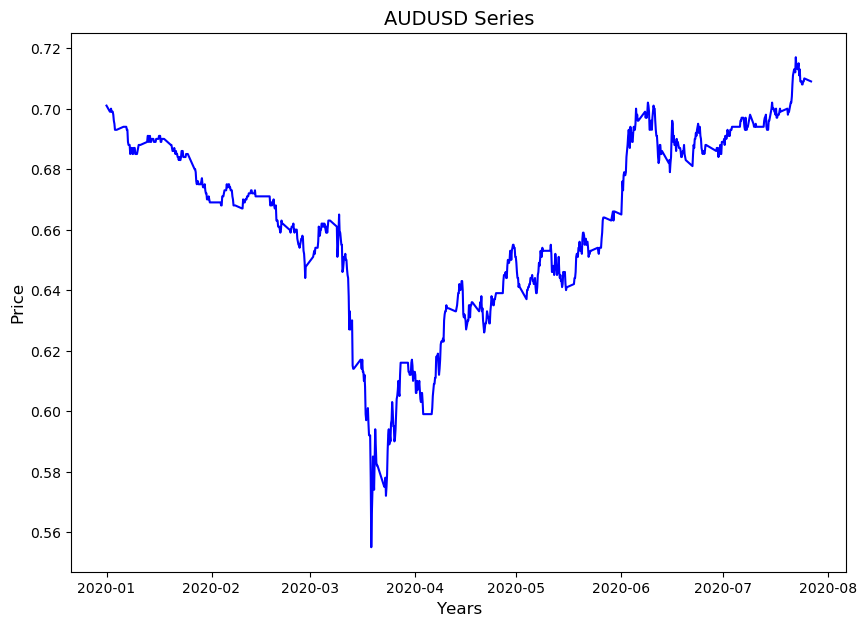

In [7]:
# Plot the series
plt.figure(figsize=(10, 7))
plt.plot(data['close'], 'blue')
plt.title("AUDUSD Series", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.show()

In [9]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['close'])

if(result[1] < 0.05):
    print('The series is stationary as the p-value = %.2f <= 0.05'
          % result[1])
else:
    print('The series is not stationary as the p-value = %.2f > 0.05'
          % result[1])

The series is not stationary as the p-value = 0.61 > 0.05


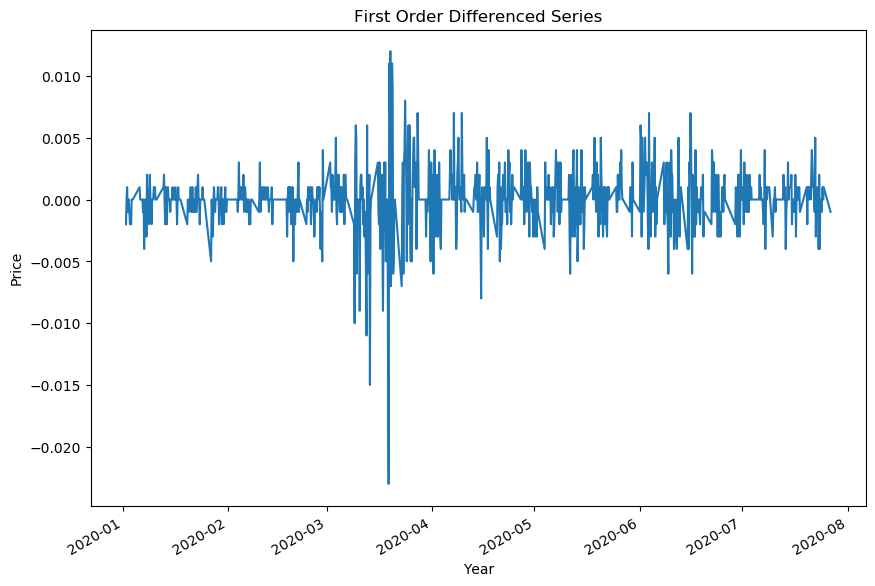

In [11]:
# Difference of the series
stationary_series = data['close'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 7))
stationary_series.plot()
plt.title('First Order Differenced Series')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [13]:
result = adfuller(stationary_series)

if(result[1] < 0.05):
    print('The series is stationary as the p-value = %.2f <= 0.05'
          % result[1])
else:
    print('The series is not stationary as the p-value = %.2f > 0.05'
          % result[1])

The series is stationary as the p-value = 0.00 <= 0.05


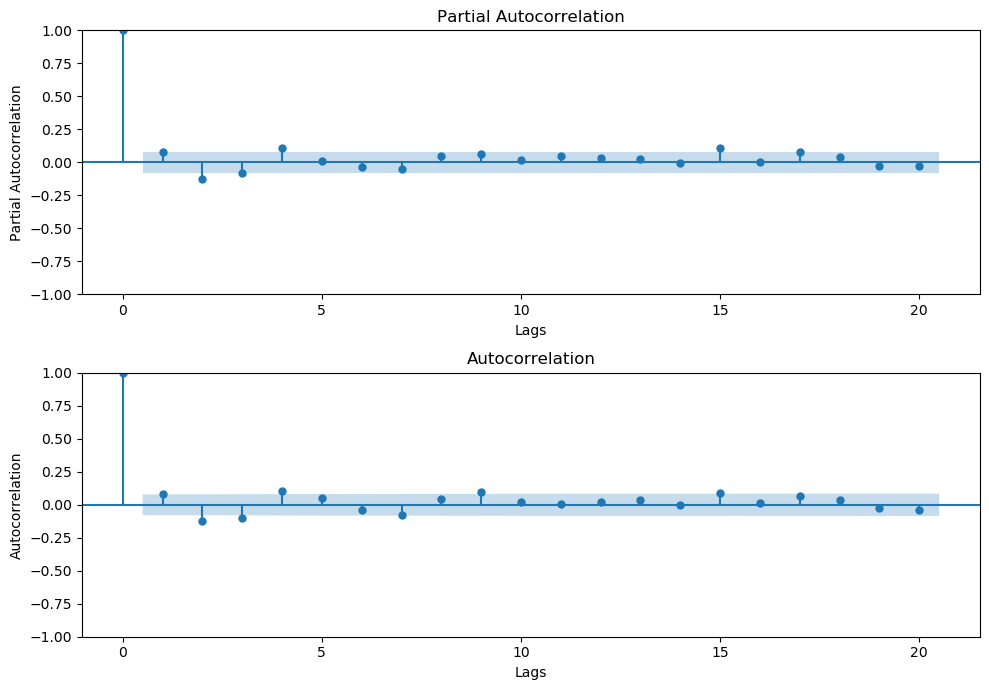

In [15]:
# Find the order of AR and MA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

# Plot Partial Autocorrelation Function
plot_pacf(data['close'][:rolling_window].diff().dropna(), lags=20, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial Autocorrelation')

# Plot Autocorrelation Function
plot_acf(data['close'][:rolling_window].diff().dropna(), lags=20, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

In [17]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima.model.ARIMA',
                        FutureWarning)

# Fit ARIMA model
model = ARIMA(data['close'][:rolling_window], order=(2, 1, 2))
model_fit_0 = model.fit()
print(model_fit_0.params.round(2))

ar.L1     0.02
ar.L2    -0.73
ma.L1     0.07
ma.L2     0.63
sigma2    0.00
dtype: float64


In [19]:
# Function to predict the price of 1 day
def predict_price_ARIMA(train_data):
    # Define model
    model = ARIMA(train_data, order=(2, 1, 2))
    # Fit the model
    model_fit = model.fit(start_params=model_fit_0.params)
    # Make forecast
    return model_fit.forecast()

In [21]:
# Predict the price using `predict_price_MA` function
data['predicted_price'] = data['close'].rolling(
    rolling_window).apply(predict_price_ARIMA)
# Shift the predicted price by 1 period
data['predicted_price'] = data['predicted_price'].shift(1)

The Mean Absolute Error is 0.00
The Mean Squared Error is 0.00
The Root Mean Squared Error is 0.00
The Mean Absolute Percentage Error is 0.23


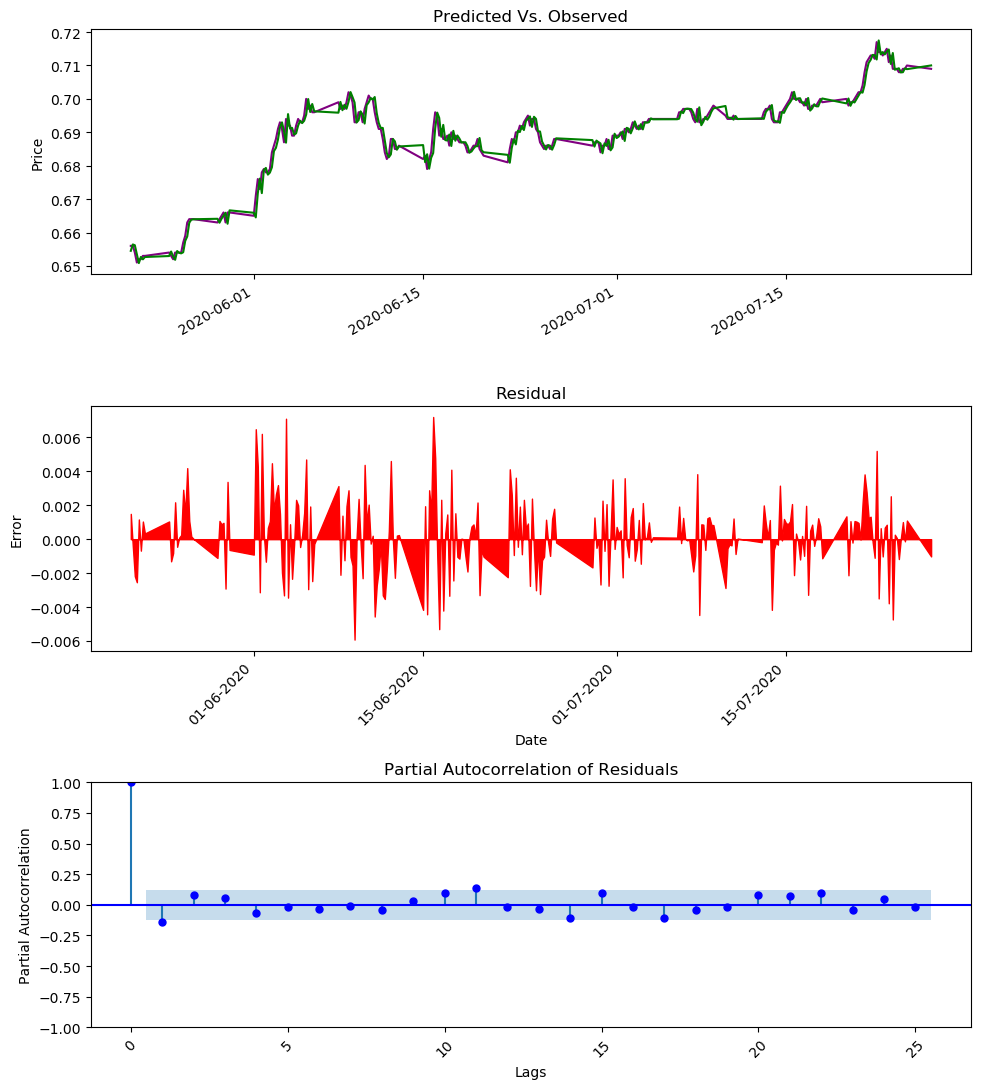

In [23]:
# Import model_performance
from xyz_function_file import model_performance

# Call `model_performance` to evaluate the performance of the model
model_performance(data['close'].iloc[rolling_window:],
                  data['predicted_price'].iloc[rolling_window:])

In [25]:
# Create signal
data['signal'] = np.where(data.predicted_price.shift(1) <
                          data.predicted_price, 1, 0)

data['returns'] = data['close'].pct_change()

data['strategy_returns'] = data.signal.shift(
    1) * data.iloc[rolling_window:].returns


The Sharpe Ratio is 1.38
The cumulative return is 5.06%
The maximum drawdown is -2.72%


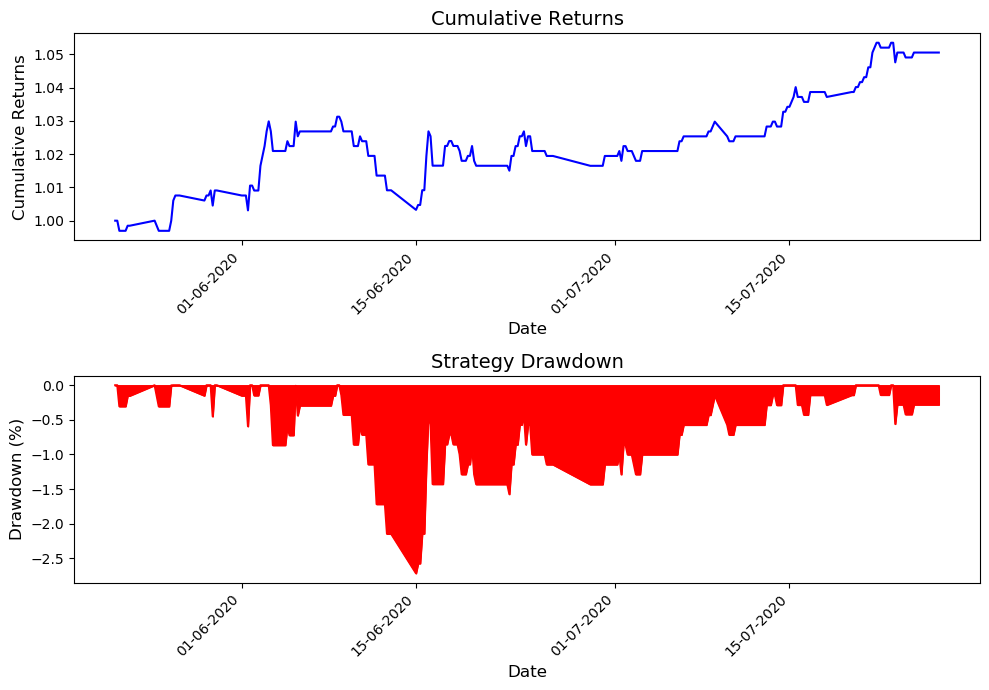

In [27]:
# Import analyse_startegy
from xyz_function_file import analyse_strategy

# Call `analyse_strategy`
analyse_strategy(data['strategy_returns'].iloc[rolling_window:])